In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib
from PIL import Image
import pyximport
pyximport.install(language_level=3)
from sims.prs import filter_PRS_histograms, get_sup_ent_lists, clean_histogram, plot_histogram
from config import COCO_PRS_json_path
charts_path = '../COCO/PRS/charts'

if not os.path.isdir(charts_path):
    os.makedirs(charts_path)

with open(COCO_PRS_json_path, 'r') as f:
    json_data = json.load(f)


def transform_prs(t, prs):
    transformed_prs = {pair : transform_hist(t, h) for pair, h in prs}
    return transformed_prs


def convert_pair(pair):
    el = pair.split(",")
    return el[0], el[1]

sup, ent = get_sup_ent_lists(json_data)

## Distribution of histograms support (PRS)
Support is distributed normally, after log10 transformation.

In [2]:
max(sup)

193971

Outliers: sup>43009, logsup>4.633562868052691
Num outliers = 8
Median(sup): 64


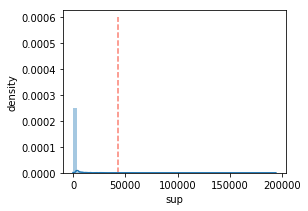

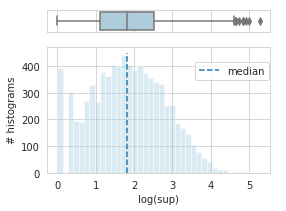

In [3]:
logsup = np.log10(sup)
fig, ax1 = plt.subplots(figsize=[4,3])
sns.distplot(sup, ax=ax1)
ax1.set_xlabel("sup")
ax1.set_ylabel("density")
sns.set_style("whitegrid")

fig, ax2 = plt.subplots(2,1, figsize=[4,3], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(logsup, ax=ax2[0], color="#a6cee3")
sns.distplot(logsup, ax=ax2[1], kde=False, norm_hist=False, color="#a6cee3")
ax2[1].set_xlabel("log(sup)")
ax2[1].set_ylabel("# histograms")


## Find Q1, Q3 and outliers
q1, med, q3 = np.quantile(logsup, [0.25, 0.5, 0.75])
iqr = q3-q1
low = q1-1.5*iqr
high = q3+1.5*iqr
ax1.vlines([int(10**high)],0,0.0006, color='#fb8072', linestyle='--', label="outliers")
ax2[1].vlines([med],0,450, color='#1f78b4', linestyle='--', label="median")
fig.legend(bbox_to_anchor=(0.95,0.65), loc="center right")

print(f"Outliers: sup>{int(round(10**high))}, logsup>{high}")
print(f"Num outliers = {(logsup>high).sum()}")
print(f"Median(sup): {int(round(10**med))}")

In [4]:
10000/10**max(logsup)*100

5.155409829304382

** What are the 8 outliers? **
They all include person (the most common object).

In [5]:
outliers = [(pair,h) for pair, h in json_data.items() if h['sup']>=int(10**high)]
outliers_clean = []
for pair, h in outliers:
    outliers_clean.append((pair, clean_histogram(h)))
outliers_clean

[('person,sky-other-merged',
  {'below': 0.792, 'entropy': 1.06, 'hanging': 0.122, 'sup': 99479}),
 ('person,tree-merged',
  {'below': 0.456, 'entropy': 1.96, 'hanging': 0.327, 'sup': 85198}),
 ('person,person',
  {'below': 0.131,
   'entropy': 2.96,
   'hanging': 0.128,
   'on': 0.153,
   'side': 0.248,
   'sup': 193971}),
 ('building-other-merged,person',
  {'above': 0.342,
   'around': 0.175,
   'entropy': 2.12,
   'on': 0.356,
   'sup': 67462}),
 ('pavement-merged,person',
  {'below': 0.393, 'entropy': 2.15, 'hanging': 0.35, 'sup': 53038}),
 ('chair,person',
  {'above': 0.161,
   'below': 0.225,
   'entropy': 2.98,
   'hanging': 0.136,
   'side': 0.126,
   'sup': 46716}),
 ('person,wall-other-merged',
  {'below': 0.223,
   'entropy': 2.56,
   'hanging': 0.365,
   'inside': 0.137,
   'sup': 67500}),
 ('person,road', {'above': 0.531, 'entropy': 2.03, 'on': 0.22, 'sup': 44043})]

## Entropy analysis
- Analyze entropy distribution with and without filtering supports

Note that **irregularities** and peaks are removed when filtering supports (this means that removing **untrusted** histograms is better).

Reference entropy values. Entr@2=0.69; entr@3=1.1
Num histograms, with ent < entr@3 = 1608


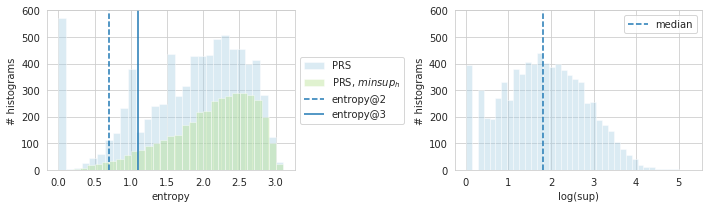

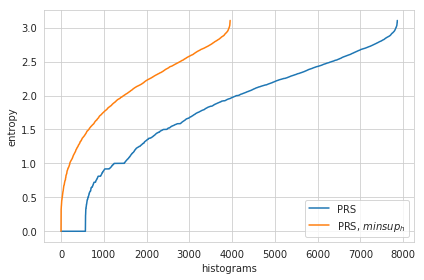

In [6]:
# Filter prs by support
minsup = int(round(10**med))
filtered_prs_minsup = filter_PRS_histograms(json_data, minsup, 1000)
_, ent_filtered_prs_minsup = get_sup_ent_lists(filtered_prs_minsup)

# Reference entropy values
entr2 = entropy([0.5,0.5])
entr3 = entropy([1/3,1/3,1/3])
entr4 = entropy([1/4,1/4,1/4,1/4])

print(f"Reference entropy values. Entr@2={round(entr2,2)}; entr@3={round(entr3,2)}")
print(f"Num histograms, with ent < entr@3 = {(ent<entr3).sum()}")

# Distribution
fig, ax = plt.subplots(1,2, figsize=[10,3], sharey=True)#7,3
sns.distplot(ent, ax=ax[0], norm_hist=False, kde=False, label="PRS", color="#a6cee3");
sns.distplot(ent_filtered_prs_minsup, ax=ax[0], norm_hist=False, kde=False, label="PRS, $minsup_h$", color="#b2df8a")
ax[0].set_xlabel("entropy")
ax[0].set_ylabel("# histograms")
ax[0].vlines([entr2],0,600, color='#1f78b4', linestyle='--', label="entropy@2")
ax[0].vlines([entr3],0,600, color='#1f78b4', linestyle='-', label="entropy@3")
ax[0].margins(y=0.0)
l = ax[0].legend(bbox_to_anchor=(1.0,0.5), loc="center left")
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)
sns.distplot(logsup, ax=ax[1], kde=False, norm_hist=False, color="#a6cee3")
ax[1].set_xlabel("log(sup)")
ax[1].set_ylabel("# histograms")
ax[1].vlines([med],0,600, color='#1f78b4', linestyle='--', label="median")
ax[1].legend()
ax[1].margins(y=0.0)
plt.tight_layout()
from matplotlib.transforms import Bbox
plt.savefig("../paperCharts/PRS_entr.eps",bbox_inches=Bbox([[0,0],[5.8,3]]))
plt.savefig("../paperCharts/PRS_sup.eps",bbox_inches=Bbox([[5.8,0],[10,3]]))

#Simple plot
fig, ax = plt.subplots()
ax.plot(np.arange(len(ent)), np.sort(ent), label="PRS");
ax.plot(np.arange(len(ent_filtered_prs_minsup)), np.sort(ent_filtered_prs_minsup), label="PRS, $minsup_h$")
ax.set_xlabel("histograms")
ax.set_ylabel("entropy")
plt.tight_layout()
l = ax.legend(bbox_to_anchor=(1,0), loc="lower right")




## Aggregation of position classes

entr3:
last 4, **last 6**. last 10.


Top 6 aggregation pairs (entr 3):
-	**below, hanging**: 1218
-	**side-down, below**: 1091
-	below, above: 1077       <-- very strange
-	**side-up, above**: 1077
-	**above, on**: 1045
-	inside, below: 1022     <-- very strange
---------------------------------
-	side-down, hanging: 950
-	side, below: 941
-	inside, above: 929
-	side-up, on: 906

===============================

entr2:
last 3. **last 5**. last 7.

Top 6 aggregation pairs (entr 2):
-   **side-down, below**: 474
-	**below, hanging**: 415
-	**side-up, above**: 388
-	**above, on**: 288
-	inside, below: 281
--------------------------------
-	side-down, hanging: 262
-	below, above: 261
-	side, below: 247
-	around, below: 243
-	around, above: 238

Worst 3 aggregation pairs:
-	around, inside: 774     -- good
-	side-down, around: 793  -- good
-	side-up, hanging: 796   -- good

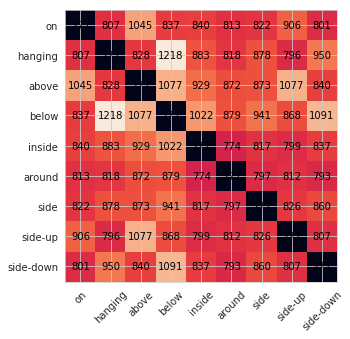

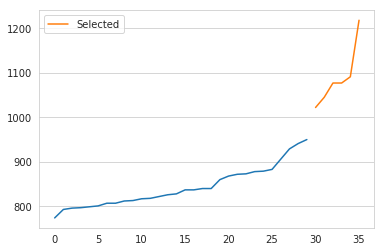

In [7]:
from config import position_labels_csv_path

def transform_hist(transform, hist):
    t_hist = {}
    for c,v in hist.items():
        if c=='entropy' or c=='sup':
            continue
        if c in transform:
            c = transform[c]
        if c in t_hist:
            t_hist[c]+=v
        else:
            t_hist[c]=v
    t_hist['entropy']=entropy(list(t_hist.values()))
    t_hist['sup']=hist['sup']
    return t_hist

with open(position_labels_csv_path,'r') as f:
    positions = ([l.strip() for l in f.readlines()])

select_entropy = entr3
# Try to aggregate all the possible pair of classes
# Make computations for histograms with sup>minsup
ent_stat=np.full([len(positions), len(positions)],(ent_filtered_prs_minsup<=select_entropy).sum())
for i,p1 in enumerate(positions):
    for j,p2 in enumerate(positions):
        if p1!=p2:
            t = {p1:p2}
            transformed_prs_i = transform_prs(t, filtered_prs_minsup.items())
            _, ent_transformed_prs_i = get_sup_ent_lists(transformed_prs_i)
            num_sel = (ent_transformed_prs_i<=select_entropy).sum()
            ent_stat[i,j]=num_sel

# Plot
cmap = matplotlib.cm.get_cmap('Spectral')

fig,ax = plt.subplots(1,1, figsize=[8,5])
ax.imshow(ent_stat)
ax.set_xticks(np.arange(len(positions)))
ax.set_xticklabels(positions, rotation=45)
ax.set_yticks(np.arange(len(positions)))
ax.set_yticklabels(positions)

for i in range(len(positions)):
    for j in range(len(positions)):
        text = ax.text(j, i, ent_stat[i, j],
                       ha="center", va="center", color="black")

plt.show()

vals=[]
for i in range(len(positions)):
    for j in range(len(positions)):
        if i<j:
            vals.append(ent_stat[i, j])
plt.figure()
plt.plot(np.sort(np.array(vals))[:-6])
plt.plot(np.arange(len(vals))[-6:], np.sort(np.array(vals))[-6:], label="Selected")
#plt.gca().set_xticks(range(0,36))
plt.legend()
plt.gca().xaxis.grid()

In [8]:
# Find best aggregations:
best_aggregations = []
worst_aggregations = []
print("Top 6 aggregation pairs:")
x,y = np.unravel_index(ent_stat.argsort(axis=None)[:-14:-1], ent_stat.shape)
for x_i,y_i in zip(x,y):
    if (x_i>y_i):
        best_aggregations.append({positions[x_i] : positions[y_i]})
        print(f"\t{positions[x_i]}, {positions[y_i]}: {ent_stat[x_i,y_i]}")
print("Worst 3 aggregation pairs:")
x,y = np.unravel_index(ent_stat.argsort(axis=None)[:15], ent_stat.shape)
for x_i,y_i in zip(x,y):
    if (x_i>y_i):
        worst_aggregations.append({positions[x_i] : positions[y_i]})
        print(f"\t{positions[x_i]}, {positions[y_i]}: {ent_stat[x_i,y_i]}")

Top 6 aggregation pairs:
	below, hanging: 1218
	side-down, below: 1091
	below, above: 1077
	side-up, above: 1077
	above, on: 1045
	inside, below: 1022
Worst 3 aggregation pairs:
	around, inside: 774
	side-down, around: 793
	side-up, hanging: 796


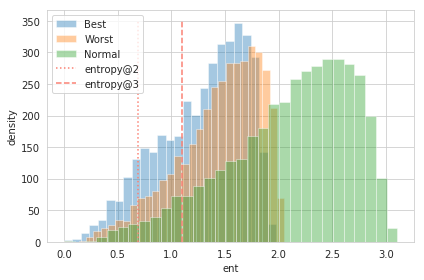

In [9]:
tBest = {'below' : 'hanging'}
_, ent_tBest = get_sup_ent_lists(transform_prs(tBest, filtered_prs_minsup.items()))
tWorst = {'around' : 'inside'}
_, ent_tWorst = get_sup_ent_lists(transform_prs(tWorst, filtered_prs_minsup.items()))

fig, ax = plt.subplots()
sns.distplot(ent_tBest, ax=ax, label='Best', kde=False, norm_hist=False);
sns.distplot(ent_tWorst, ax=ax, label='Worst', kde=False, norm_hist=False, );
sns.distplot(ent_filtered_prs_minsup, ax=ax, label='Normal', kde=False, norm_hist=False);
ax.set_xlabel("ent")
ax.set_ylabel("density")
plt.tight_layout()

ax.vlines([entr2],0,350, color='#fb8072', linestyle=':', label="entropy@2")
ax.vlines([entr3],0,350, color='#fb8072', linestyle='--', label="entropy@3")
l = ax.legend()

- Note that **Best** aggregation **changes** the distribution and maximizes the number of lower entropies.
- **Worst** aggregation implies only a **translation** of the distribution

Let's verify this:

Best aggregations, by type.
floor-other-merged,rock-merged {'hanging': 0.305, 'below': 0.284, 'sup': 95, 'entropy': 2.68}
pizza,sandwich {'below': 0.285, 'side-down': 0.158, 'sup': 165, 'entropy': 2.95}
book,book {'below': 0.271, 'above': 0.228, 'sup': 36781, 'entropy': 2.89}
backpack,dog {'above': 0.245, 'side-up': 0.236, 'sup': 110, 'entropy': 2.87}
cow,pavement-merged {'on': 0.336, 'above': 0.269, 'sup': 301, 'entropy': 2.59}
car,mirror-stuff {'inside': 0.347, 'below': 0.271, 'hanging': 0.124, 'sup': 225, 'entropy': 2.56}


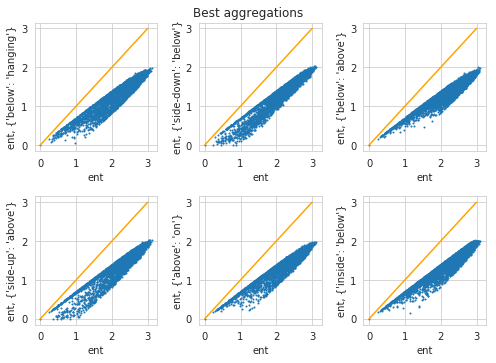

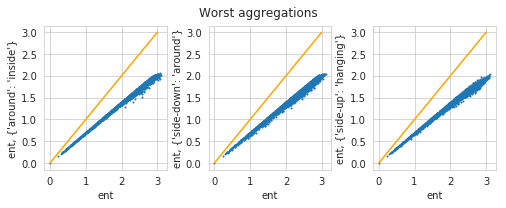

In [10]:
plt.figure(figsize=[7,5])
plt.suptitle("Best aggregations", y=1)
print("Best aggregations, by type.")
for i, tBest in enumerate(best_aggregations):
    ax = plt.subplot(2, 3, i+1)
    transformed_prs_i = transform_prs(tBest, filtered_prs_minsup.items())
    _, ent_transformed_prs_i = get_sup_ent_lists(transformed_prs_i)
    
    # Select best change
    best_transform_index = (np.array(ent_filtered_prs_minsup) - np.array(ent_transformed_prs_i)).argsort()[-1]
    best_transform = list(filtered_prs_minsup.items())[best_transform_index]
    print(best_transform[0], clean_histogram(best_transform[1]))
    
    ax.scatter(ent_filtered_prs_minsup, ent_transformed_prs_i, s=1)
    ax.plot(np.linspace(0,3), np.linspace(0,3), color="orange")
    ax.set_ylabel(f"ent, {tBest}")
    ax.set_xlabel("ent")
plt.tight_layout()

plt.figure(figsize=[7,5])
plt.suptitle("Worst aggregations", y=1)
for i, tWorst in enumerate(worst_aggregations):
    ax = plt.subplot(2, 3, i+1)
    transformed_prs_i = transform_prs(tWorst, filtered_prs_minsup.items())
    _, ent_transformed_prs_i = get_sup_ent_lists(transformed_prs_i)
      
    ax.scatter(ent_filtered_prs_minsup, ent_transformed_prs_i, s=1)
    ax.plot(np.linspace(0,3), np.linspace(0,3), color="orange")
    ax.set_ylabel(f"ent, {tWorst}")
    ax.set_xlabel("ent")
plt.tight_layout()

- As you can see, **Worst** aggregations are **linearly dependent** with originl entropy.
It just means that the entropy values decrease all together only because 1 position class has been removed.
- **Best** aggregations, instead are more "scattered" because the transformation has a very good benefit to a subset of the histograms (i.e. those where the merged classes have **similar semantic meaning**).

Moreover, examples of good merge:
- 'floor-other-merged', 'rock-merged' {'below': 0.284, 'hanging': 0.305} -> **Below+hanging**
- 'pizza', 'sandwich' {'side-down': 0.158, 'below': 0.285} -> **Side-down+below**
- 'book', 'book' {'below': 0.271, 'above': 0.228} -> **above+blow**
- 'backpack', 'dog' {'above': 0.245, 'side-up': 0.236} -> **above+side-up**
- 'cow', 'pavement-merged' {'above': 0.269, 'on': 0.336} -> **above+on**
- 'car', 'mirror-stuff' {'below': 0.271, 'hanging': 0.124, 'inside': 0.347} -> **below+hanging**

For example book is above or below other books.

## Selection of best histograms
We pick histograms with $sup>median$ and $ent<ent@3$

Number of selected histograms: 277


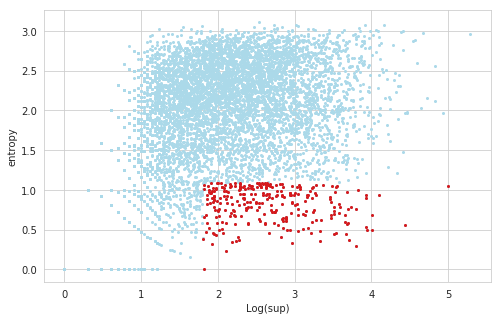

In [11]:
# Filter histograms
filtered_prs = filter_PRS_histograms(json_data, minsup, entr3)
sup_filtered, ent_filtered = get_sup_ent_lists(filtered_prs)
print(f"Number of selected histograms: {len(filtered_prs)}")

# Plot scatterplot
plt.figure(figsize=(8, 5))
plt.plot(np.log10(sup), ent, c='#abd9e9', linestyle='', marker='o', markersize=2)
plt.xlabel("Log(sup)")
plt.ylabel("entropy")
plt.grid()
plt.plot(np.log10(sup_filtered), ent_filtered, c='#d7191c', linestyle='', marker='o', markersize=2)
plt.grid()

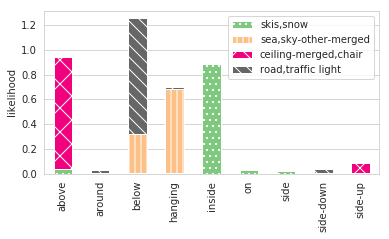

In [12]:
sorted_prs = sorted(list(filtered_prs.items()),key=lambda it: it[1]['entropy'])
ex1 = [(p,h,3)for p,h in sorted_prs if 'inside' in clean_histogram(h)][0]
ex2 = [(p,h,3) for p,h in sorted_prs if 'hanging' in clean_histogram(h)][3]#1
ex3 = [(p,h,3) for p,h in sorted_prs if 'above' in clean_histogram(h)][9]
ex4 = [(p,h,3) for p,h in sorted_prs if 'below' in clean_histogram(h)][16]

df = pd.DataFrame([ex1[1],ex2[1],ex3[1],ex4[1]], index=[ex1[0],ex2[0],ex3[0],ex4[0]])
fig,ax = plt.subplots(figsize=[6,3])
df2 = df.drop(columns=['entropy','sup']).transpose()
df2.plot(kind='bar', stacked=True, cmap='Accent',figsize=[6,3], ax=ax)

bars = ax.patches
patterns =('..', '||', 'x','\\\\')
hatches = [p for p in patterns for i in range(len(df2))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
plt.grid(axis='x')
plt.ylabel("likelihood")
plt.legend()
fig.savefig('../paperCharts/histExamples.eps',bbox_inches = 'tight')

/home/andrea/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/home/andrea/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


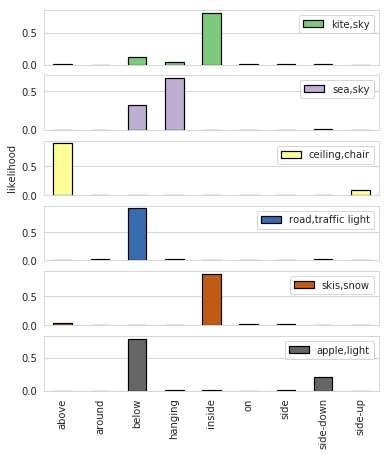

In [13]:
sorted_kb = sorted(list(filtered_prs.items()),key=lambda it: it[1]['entropy'])
n=6
#figsize=[6,3] #n=4
figsize=[6,7] #n=4
ex = [None for i in range(n)]

ex[0] =['kite,sky', filtered_prs['kite,sky-other-merged']] # Second paper version 'kite,sky-other-merged'
ex[1] = [(p.replace("-other-merged",""),h,3) for p,h in sorted_prs if 'hanging' in clean_histogram(h)][3]#1
ex[2] = [(p.replace("-merged",""),h,3) for p,h in sorted_prs if 'above' in clean_histogram(h)][9]
ex[3] = [(p,h,3) for p,h in sorted_prs if 'below' in clean_histogram(h)][16]
ex[4] = [(p,h,3)for p,h in sorted_prs if 'inside' in clean_histogram(h)][0]
ex[5] = [(p,h,3) for p,h in sorted_prs if 'side-down' in clean_histogram(h)][0]


df = pd.DataFrame([exi[1] for exi in ex], index=[exi[0] for exi in ex])
fig,ax = plt.subplots(figsize=figsize)
df2 = df.drop(columns=['entropy','sup']).transpose()
axs = df2.plot(title=['' for i in range(n)], kind='bar', subplots=True, stacked=False, sharex=True, cmap='Accent', edgecolor='black', linewidth=1.2, ax=ax)

for i in range(n):
    plt.axes(axs[i])
    plt.grid(axis='x')
    if i==2:
        plt.ylabel("likelihood")
plt.legend()
fig.savefig('../paperCharts/histExamples.eps',bbox_inches = 'tight')

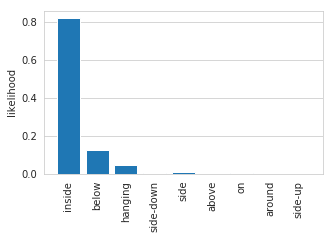

In [14]:
plot_histogram(filtered_prs['kite,sky-other-merged'])

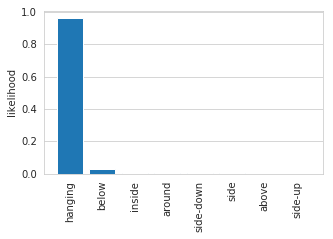

In [15]:
plot_histogram(filtered_prs['mountain-merged,sky-other-merged'])

In [16]:
entropy([1/4,1/4,1/4,1/4])

1.3862943611198906

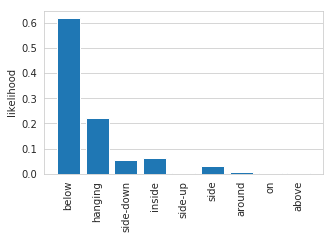

In [17]:
plot_histogram(json_data['boat,mountain-merged'])

In [18]:
for k,v in filtered_prs.items():
    if 'floor' in k:
        print(k)

['floor-wood,tv']

floor-other-merged,sky-other-merged
clock,floor-other-merged
ceiling-merged,floor-other-merged
floor-other-merged,mountain-merged
ceiling-merged,floor-wood
clock,floor-wood
floor-wood,sink
floor-wood,tv
floor-wood,window-blind
floor-other-merged,traffic light
floor-other-merged,roof
car,floor-wood
floor-other-merged,microwave
floor-wood,microwave
floor-other-merged,toothbrush
floor-wood,sky-other-merged
floor-wood,roof
floor-wood,tie


['floor-wood,tv']

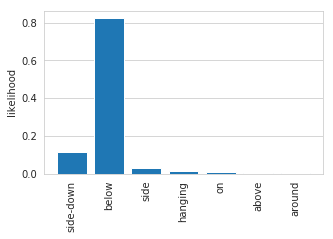

In [19]:
plot_histogram(filtered_prs['floor-wood,tv'])

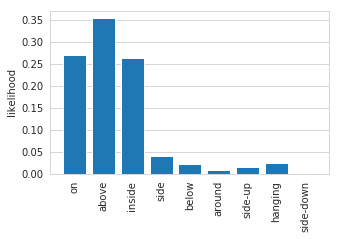

In [20]:
plot_histogram(json_data['person,sand'])

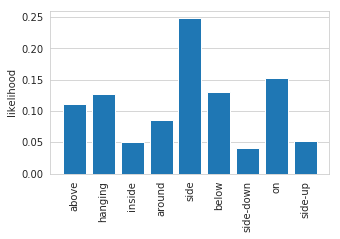

In [21]:
plot_histogram(json_data['person,person'])

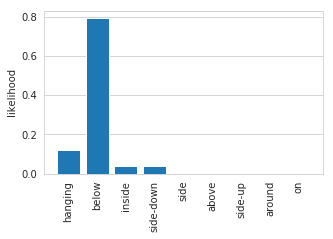

In [22]:
plot_histogram(json_data['person,sky-other-merged'])

In [35]:
sorted(json_data.items(), key=lambda x: -float(x[1]['entropy']))


[('fruit,paper-merged',
  {'above': 0.13157894736842105,
   'around': 0.1023391812865497,
   'below': 0.13450292397660818,
   'entropy': 3.1067849875324134,
   'hanging': 0.12280701754385964,
   'inside': 0.09649122807017543,
   'on': 0.11403508771929824,
   'side': 0.1695906432748538,
   'side-down': 0.07309941520467836,
   'side-up': 0.05555555555555555,
   'sup': 342}),
 ('orange,orange',
  {'above': 0.12536909448818898,
   'around': 0.06016240157480315,
   'below': 0.1733513779527559,
   'entropy': 3.0785821957244437,
   'hanging': 0.14628444881889763,
   'inside': 0.05647145669291338,
   'on': 0.1435777559055118,
   'side': 0.11331200787401575,
   'side-down': 0.07246555118110236,
   'side-up': 0.10900590551181102,
   'sup': 8128}),
 ('cow,sheep',
  {'above': 0.12361623616236163,
   'around': 0.16974169741697417,
   'below': 0.16789667896678967,
   'entropy': 3.074874396541401,
   'hanging': 0.07933579335793357,
   'inside': 0.13468634686346864,
   'on': 0.09225092250922509,
   's

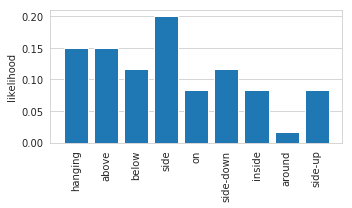

In [42]:
plot_histogram(json_data['handbag,towel'])
plt.tight_layout()
plt.savefig('../paperCharts/highEntropy.eps')